In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import xarray as xr
from dask.diagnostics import ProgressBar

from simulation_tutorial import xarray_mods as xrmod


## Influence of spin bath on electron Ramsey

Loosly based on https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/time-evolution/003_qubit-dynamics.ipynb

In [2]:
def ramsey(time_array_s, detuning_hz=0):
    H = detuning_hz * 2 * np.pi * qt.sigmaz() / 2.0
    initial_state = 1 / np.sqrt(2) * (qt.basis(2, 0) + qt.basis(2, 1))
    result = qt.mesolve(H, initial_state, time_array_s, e_ops=[qt.sigmax()])
    sx_timetrace = result.expect[0]
    return sx_timetrace

Text(0, 0.5, 'sx')

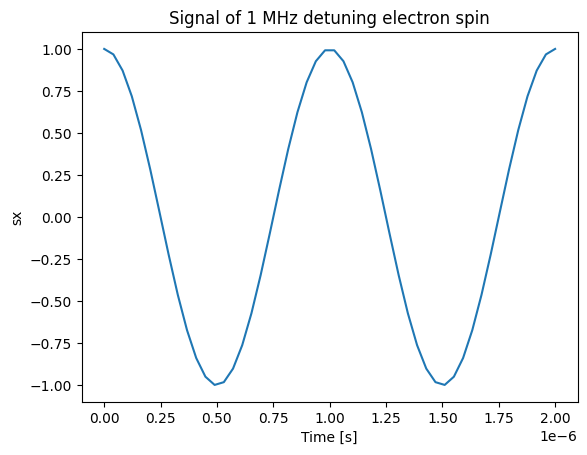

In [3]:
time_array_s = np.linspace(0, 2e-6)
sx = ramsey(time_array_s, 1e6)
plt.plot(time_array_s, sx)
plt.title("Signal of 1 MHz detuning electron spin")
plt.xlabel("Time [s]")
plt.ylabel("sx")

# Using apply_ufunc

In [65]:
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * 1e-6
ds["detuning_Mhz"] = 1
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * 1e6
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True
)
ds.sx.attrs = {"long_name": r"$\sigma_x$"}
ds

<xarray.Dataset> Size: 2kB
Dimensions:       (time_us: 100)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  int64 8B 1
    detuning_hz   float64 8B 1e+06
    sx            (time_us) float64 800B 1.0 0.992 0.9679 ... 0.9679 0.992 1.0

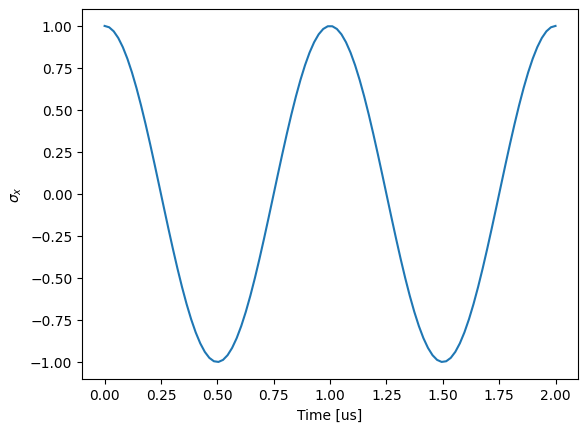

In [67]:
ds.sx.plot()

## How would a fluctuation bath show up in a Ramsey measurement

In [70]:
from simulation_tutorial import xarray_mods as xrmod

US_TO_S = 1e-6
MHZ_TO_HZ = 1e6

In [72]:
number_of_mc_realizations = 1000
mean_distribution_MHz = 0
sigma_distribution_MHz = 0.5
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds["detuning_Mhz"] = xr.DataArray(np.random.normal(
    mean_distribution_MHz, 
    sigma_distribution_MHz, 
    number_of_mc_realizations
    ), dims='mc')
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
)
ds.sx.attrs = {"long_name": r"$\sigma_x$"}
ds


<xarray.Dataset> Size: 818kB
Dimensions:       (time_us: 100, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  (mc) float64 8kB 0.5565 0.2707 -0.3298 ... -0.5688 -0.6925
    detuning_hz   (mc) float64 8kB 5.565e+05 2.707e+05 ... -5.688e+05 -6.925e+05
    sx            (mc, time_us) float64 800kB 1.0 0.9975 ... -0.6887 -0.7497

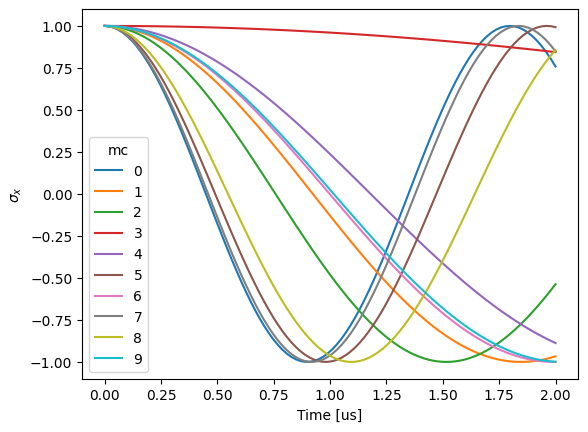

In [73]:
ds.sx.isel(mc=slice(0,10)).plot(hue='mc');

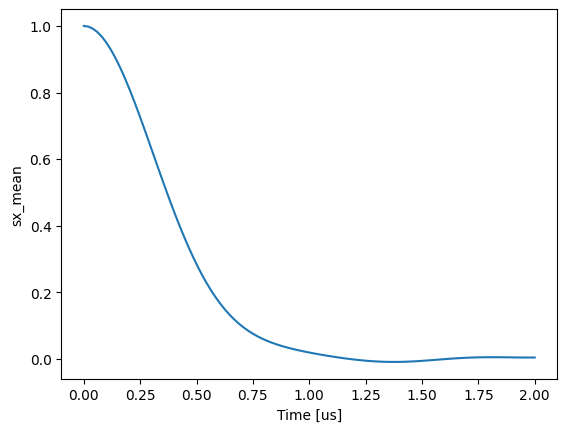

In [74]:
ds['sx_mean'] = ds.sx.mean("mc")
ds.sx_mean.plot();

## Now lets use multiprocessing

In [75]:
from simulation_tutorial import xarray_mods as xrmod

In [83]:
number_of_mc_realizations = 1000
mean_distribution_MHz = 0
sigma_distribution_MHz = 0.5
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds["detuning_Mhz"] = xr.DataArray(np.random.normal(
    mean_distribution_MHz, 
    sigma_distribution_MHz, 
    number_of_mc_realizations
    ), dims='mc')
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
    multiprocessing=True,
    chunksize=1
)
ds.sx.attrs = {"long_name": r"$\sigma_x$"}
ds["sx_exp"] = ds.sx.mean("mc")
ds.sx_exp.attrs = {"long_name": r"$\sigma_x$"}
ds

100%|██████████| 1000/1000 [00:00<00:00, 1020.10it/s]


<xarray.Dataset> Size: 818kB
Dimensions:       (time_us: 100, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  (mc) float64 8kB 0.108 -0.3999 0.1414 ... -0.4166 0.1495
    detuning_hz   (mc) float64 8kB 1.08e+05 -3.999e+05 ... -4.166e+05 1.495e+05
    sx            (mc, time_us) float64 800kB 1.0 0.9999 ... 0.4528 0.4993
    sx_exp        (time_us) float64 800B 1.0 0.9979 0.9915 ... 0.02325 0.02407

# Double sweep

In [97]:
number_of_mc_realizations = 1000
mean_distribution_MHz = 0
sigma_distribution_MHz = 0.5
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds['sigma_MHz'] = np.arange(0.2, 0.82, 0.1)
ds.sigma_MHz.attrs = {"long_name": "Sigma", "units": "MHz"}
ds["detuning_Mhz"] = xr.apply_ufunc(
    np.random.normal,
    mean_distribution_MHz, 
    ds.sigma_MHz,
    number_of_mc_realizations,
    output_core_dims=[['mc']],
    vectorize=True)
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
    multiprocessing=False,
    chunksize=100
)
ds.sx.attrs = {"long_name": r"$\sigma_x$"}
ds["sx_exp"] = ds.sx.mean("mc")
ds.sx_exp.attrs = {"long_name": r"$\sigma_x$"}
ds

<xarray.Dataset> Size: 6MB
Dimensions:       (time_us: 100, sigma_MHz: 7, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
  * sigma_MHz     (sigma_MHz) float64 56B 0.2 0.3 0.4 0.5 0.6 0.7 0.8
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  (sigma_MHz, mc) float64 56kB -0.3774 -0.05664 ... 1.321 1.345
    detuning_hz   (sigma_MHz, mc) float64 56kB -3.774e+05 ... 1.345e+06
    sx            (sigma_MHz, mc, time_us) float64 6MB 1.0 0.9989 ... -0.3718
    sx_exp        (sigma_MHz, time_us) float64 6kB 1.0 0.9997 ... -0.0009293

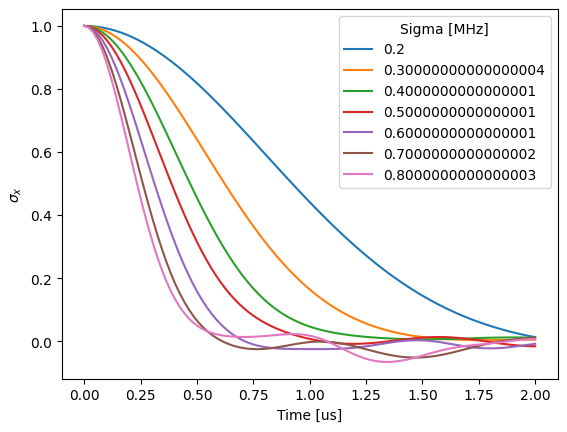

In [92]:
ds.sx_exp.plot(hue="sigma_MHz");

## Multiprocessing using dask

To speed this up we can use `dask` arrays which can do multiprocessing.
For this we need to chuck the data in parts that we want to run at once.
You cannot call the `chunk` directly on a coordinate of a dataset. Therefore you first need to pass it to `xr.DataArray`

In [98]:
number_of_mc_realizations = 1000
mean_distribution_MHz = 0
sigma_distribution_MHz = 0.5
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds['sigma_MHz'] = np.arange(0.2, 0.82, 0.1)
ds.sigma_MHz.attrs = {"long_name": "Sigma", "units": "MHz"}
ds["detuning_Mhz"] = xr.apply_ufunc(
    np.random.normal,
    mean_distribution_MHz, 
    ds.sigma_MHz,
    number_of_mc_realizations,
    output_core_dims=[['mc']],
    vectorize=True)
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    xr.DataArray(ds.detuning_hz).chunk(50),
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
)
ds.sx.attrs = {"long_name": r"$\sigma_x$"}
ds["sx_exp"] = ds.sx.mean("mc")
ds.sx_exp.attrs = {"long_name": r"$\sigma_x$"}
with ProgressBar():
    ds = ds.compute(scheduler="processes")
ds

[########################################] | 100% Completed | 14.64 s


<xarray.Dataset> Size: 6MB
Dimensions:       (time_us: 100, sigma_MHz: 7, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
  * sigma_MHz     (sigma_MHz) float64 56B 0.2 0.3 0.4 0.5 0.6 0.7 0.8
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  (sigma_MHz, mc) float64 56kB -0.007668 0.02736 ... 1.088
    detuning_hz   (sigma_MHz, mc) float64 56kB -7.668e+03 ... 1.088e+06
    sx            (sigma_MHz, mc, time_us) float64 6MB 1.0 1.0 ... 0.5649 0.4459
    sx_exp        (sigma_MHz, time_us) float64 6kB 1.0 0.9997 ... 0.04689